In [161]:
import pandas as pd
import numpy as np

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

### Import data

In [124]:
data = pd.read_csv('../data_scraping.csv', engine='python')

In [125]:
# Remove ill-formated lines
data = data[data.text.notnull()]

In [126]:
data.source.value_counts()

bestbuy            13281
youtube             8820
reddit              8441
gsm arena           5798
twitter             5016
amazon               842
flipkart             436
at&t                 424
influenster          248
google shopping      156
Name: source, dtype: int64

In [127]:
# Remove youtube and twitter
data = data[data["source"].map(lambda x: x not in ["youtube", "twitter"])]

### Processing

#### First steps

In [128]:
# Remove ponctuation
matrix = str.maketrans(",\"_;", "    ", "'’.()/-?!|:><&[]*")
data["text"] = data["text"].transform(lambda x: x.translate(matrix))

In [129]:
# Remove bad characters
data["text"] = data["text"].transform(lambda text: ''.join([x for x in text if ord(x)<128]))

In [130]:
# Remove empty lines
data = data.loc[~(data["text"].map(lambda x: x.strip()==''))]

In [ ]:
# Language detection
from textblob import TextBlob

def filter_language(text, allowed_languages=["en"]):
    try:
        blob = TextBlob(text)
        return (blob.detect_language() in allowed_languages)
    except:
        pass
    finally:
        return False

data["text"].apply(filter_language)

In [131]:
data.head()

,source,text
0,bestbuy,Definitely this is the best phone I have ever ...
1,reddit,even the oneplus is creeping up in price\n\nOP...
3,reddit,Id imagine doing it to ensure you get it befor...
6,bestbuy,This is the best iphone to date Very fast and ...
8,reddit,Fair point I usually am not thinking about fi...


#### Tokenize

In [132]:
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords

tweet = TweetTokenizer(preserve_case=False, strip_handles=True, reduce_len=True)
stopwords = set(stopwords.words('english'))

# Tokenize
data["text"] = data["text"].transform(tweet.tokenize)

In [133]:
# Remove stopwords
data["text"] = data["text"].transform(lambda x: [token for token in x if not token in stopwords])

In [134]:
# Remove short lines
data = data[data["text"].apply(lambda x: len(x) > 4)]

In [135]:
# Remove dates or numbers that are not phone models, and hashtags
import re
xp = re.compile("[0-9]{2,}|#\w+")
data["text"] = data["text"].apply(lambda tokens: [x for x in tokens if not xp.match(x)])

In [136]:
# Checkpoint
data.groupby("source").head(10)

,source,text
0,bestbuy,"[definitely, best, phone, ever, great, design,..."
1,reddit,"[even, oneplus, creeping, price, opo, used, op..."
3,reddit,"[id, imagine, ensure, get, sells]"
6,bestbuy,"[best, iphone, date, fast, clear, picture, qui..."
8,reddit,"[fair, point, usually, thinking, filming, bc, ..."
9,bestbuy,"[iphone, 8, premium, feel, great, screen, reso..."
16,gsm arena,"[angry, one, little, bit, disagreed, saying, t..."
17,bestbuy,"[havent, new, phone, 5, years, love, new, sams..."
18,reddit,"[dont, think, possible, work, vzws, cloud, ven..."
19,bestbuy,"[great, phone, worth, money, sturdy, efficient..."


### Stemming

##### First attempt

In [17]:
from nltk.stem.snowball import SnowballStemmer

In [18]:
stemmer = SnowballStemmer('english')

def stemming(tokens):
    excluded = set(['iphone'])
    return [stemmer.stem(token) if token not in excluded else token for token in tokens]

In [19]:
data["review_text"].transform(stemming)

0       [ive, appl, sinc, day, 1, 2007, x, far, best, ...
1       [went, 6, matter, transfer, one, phone, anoth,...
2       [love, phone, upgrad, howev, fragil, difficult...
3       [super, excit, get, phone, preorder, wait, anx...
4       [hype, substanc, facial, recognit, system, nic...
5       [saw, first, ad, iphone, x, like, want, phone,...
6       [cant, understand, negat, review, own, everi, ...
7       [pick, x, releas, date, worri, home, button, w...
8       [durabl, glass, ever, laugh, attach, pic, ipho...
9       [within, hour, get, phone, set, saw, there, 8m...
10      [appl, done, 4k, 60fps, 4k, 24fps, one, even, ...
11      [like, iphon, ive, own, phone, function, perfe...
12      [respond, comment, earlier, post, iphone, x, s...
13      [surf, internet, realli, truli, fast, almost, ...
14      [admit, scare, order, phone, went, far, make, ...
15      [hate, new, phone, need, remodel, everyth, thi...
16      [love, screen, clariti, im, hard, time, let, g...
17      [ive, 

### Lemmatization

In [137]:
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

In [138]:
def lemming(tokens):
    return [lemmatizer.lemmatize(token, pos="v") for token in tokens]

In [139]:
data["text"] = data["text"].transform(lemming)

In [140]:
data.groupby("source").head(10)

,source,text
0,bestbuy,"[definitely, best, phone, ever, great, design,..."
1,reddit,"[even, oneplus, creep, price, opo, use, op5, +]"
3,reddit,"[id, imagine, ensure, get, sell]"
6,bestbuy,"[best, iphone, date, fast, clear, picture, qui..."
8,reddit,"[fair, point, usually, think, film, bc, im, tr..."
9,bestbuy,"[iphone, 8, premium, feel, great, screen, reso..."
16,gsm arena,"[angry, one, little, bite, disagree, say, thats]"
17,bestbuy,"[havent, new, phone, 5, years, love, new, sams..."
18,reddit,"[dont, think, possible, work, vzws, cloud, ven..."
19,bestbuy,"[great, phone, worth, money, sturdy, efficient..."


In [141]:
# Custom tokens
def custom_lemming(tokens):
    processed = []
    append = processed.append
    for i, token in enumerate(tokens):
        if token == "iphone":
            continue
        if token == "x" or token == "10":
            append("iphoneX")
            continue
        if token == "6":
            if i>0 and tokens[i-1] == "iphone":
                append("iphone6")
            continue
        if token == "7":
            if i>0 and tokens[i-1] == "iphone":
                append("iphone7")
            continue
        if token == "face":
            append("faceid")
            continue
        if token == "id":
            if i>0 and tokens[i-1] == "face":
                append("faceid")
            continue
        if token in ["+"]:
            continue
        append(token)
    return processed

In [143]:
data["text"] = data["text"].transform(custom_lemming)

# TF IDF

In [163]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(max_features=70, norm='l2', min_df=0.08, max_df=0.8, ngram_range=(1, 1))

In [164]:
tfidf_matrix = tfidf.fit_transform(data["text"].transform(lambda x: ' '.join(x)))

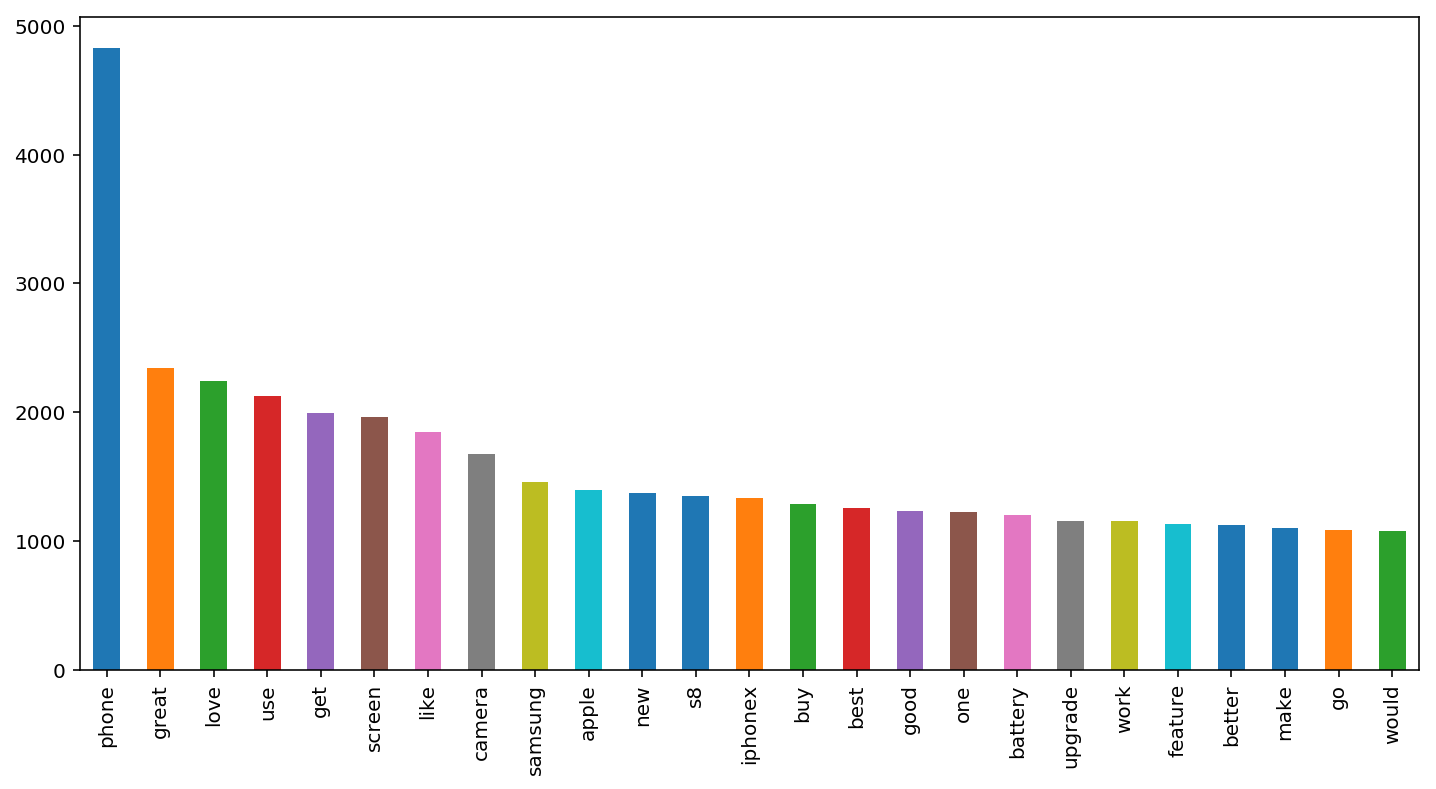

In [165]:
pd.DataFrame(tfidf_matrix.todense(), columns=tfidf.get_feature_names()).apply(sum, axis=0).sort_values(ascending=False).plot(kind="bar", figsize=(12,6))